# SingleCell Data Analysis on the GPU with Pearson Residuals
**Author:** [Severin Dicks](https://github.com/Intron7)

To run this notebook please make sure you have a working rapids enviroment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of 500000 brain cells from  [Nvidia](https://github.com/clara-parabricks/rapids-single-cell-examples/blob/master/notebooks/1M_brain_cpu_analysis.ipynb).

In [1]:
import scanpy as sc
import anndata
import cupy as cp

import time
import rapids_singlecell as rsc

import warnings
warnings.filterwarnings("ignore")

In [2]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
rmm.reinitialize(
    managed_memory=False, # Allows oversubscription
    pool_allocator=False, # default is False
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)


## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [3]:
data_load_start = time.time()

In [4]:
%%time
adata = sc.read("h5/500000.h5ad")
adata.var_names_make_unique()

CPU times: user 624 ms, sys: 5.73 s, total: 6.35 s
Wall time: 1min 1s


In [5]:
adata.shape

(500000, 27998)

In [6]:
%%time
rsc.utils.anndata_to_GPU(adata)

CPU times: user 1.82 s, sys: 2.1 s, total: 3.92 s
Wall time: 3.93 s


Verify the shape of the resulting sparse matrix:

And the number of non-zero values in the matrix:

In [7]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 65.30319333076477


## Preprocessing

In [8]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

In [9]:
%%time
rsc.pp.flag_gene_family(adata,gene_family_name="MT", gene_family_prefix="mt-")

CPU times: user 4.75 ms, sys: 739 µs, total: 5.49 ms
Wall time: 5.34 ms


In [10]:
%%time
rsc.pp.calculate_qc_metrics(adata,qc_vars=["MT"])

CPU times: user 150 ms, sys: 14.9 ms, total: 165 ms
Wall time: 240 ms


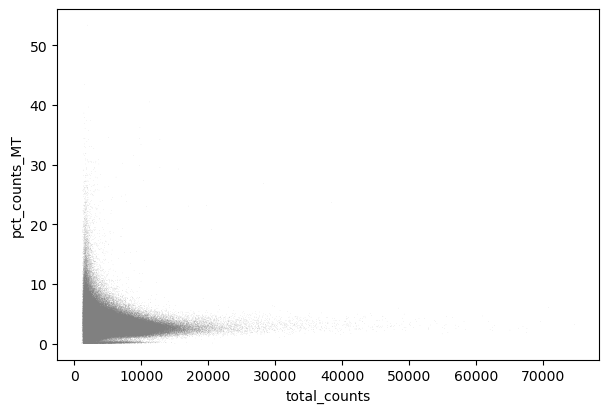

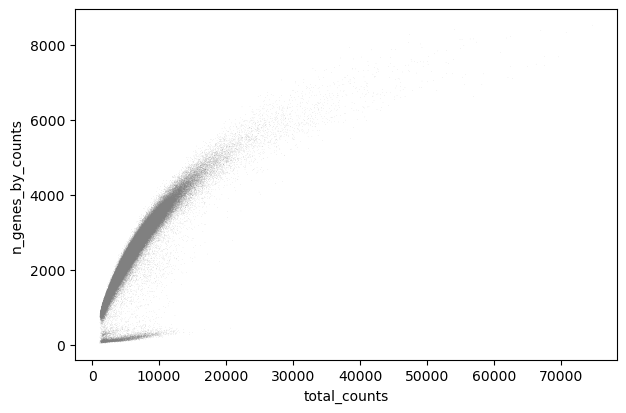

In [11]:
sc.pl.scatter(adata,"total_counts","pct_counts_MT")
sc.pl.scatter(adata,"total_counts","n_genes_by_counts")

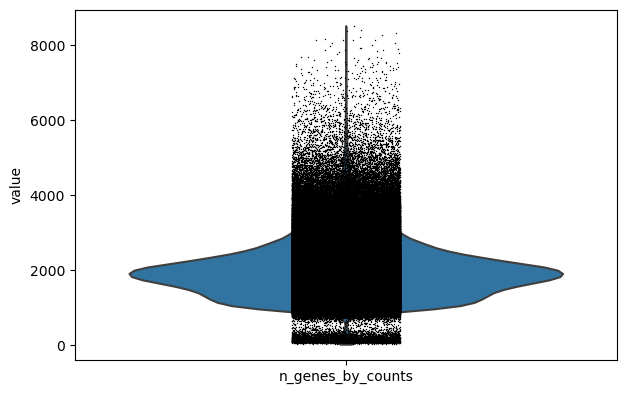

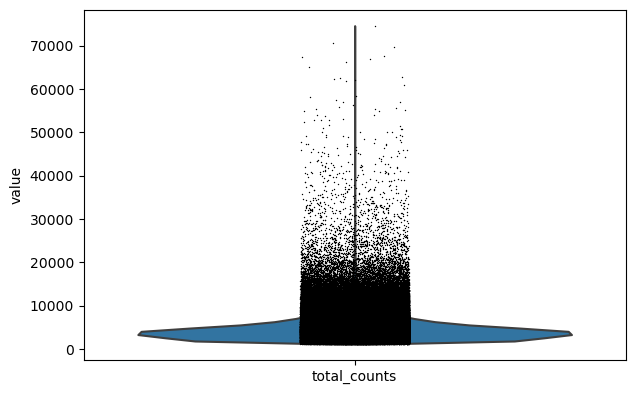

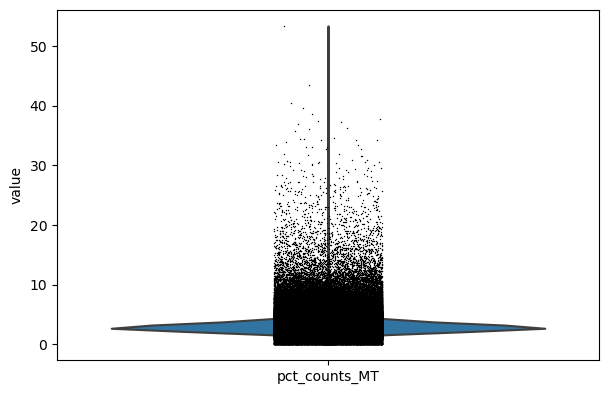

In [12]:
sc.pl.violin(adata,keys="n_genes_by_counts")
sc.pl.violin(adata,keys="total_counts")
sc.pl.violin(adata,keys="pct_counts_MT")

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.
We also filter out cells with a mitchondrial countent of more than 20%.

The size of our count matrix is now reduced.

In [13]:
%%time
rsc.pp.filter_genes(adata, min_count=10)

filtered out 7663 genes based on n_cells_by_counts
CPU times: user 494 ms, sys: 86.2 ms, total: 580 ms
Wall time: 598 ms


In [14]:
%%time
rsc.pp.filter_cells(adata,qc_var="n_genes_by_counts", min_count=500,max_count= 4000)
rsc.pp.filter_cells(adata,qc_var="total_counts", max_count= 20000)
adata = adata[adata.obs["pct_counts_MT"] < 20]

filtered out 15844 cells
filtered out 5 cells
CPU times: user 162 ms, sys: 58.2 ms, total: 220 ms
Wall time: 748 ms


We copy the raw counts to the layer `counts`

In [15]:
adata.layers["counts"] = adata.X.copy()

### Log-Normalize counts

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [16]:
%%time
rsc.pp.normalize_total(adata,target_sum=1e4)

CPU times: user 417 µs, sys: 1.46 ms, total: 1.88 ms
Wall time: 8.89 ms


Next, we log transform the count matrix.

In [17]:
%%time
rsc.pp.log1p(adata)

CPU times: user 24.8 ms, sys: 7.36 ms, total: 32.2 ms
Wall time: 44.8 ms


Now we safe this verion of the AnnData as adata.raw.

In [18]:
%%time
adata.raw = adata

CPU times: user 629 ms, sys: 476 ms, total: 1.11 s
Wall time: 1.11 s


### Select Most Variable Genes

Now we search for highly variable genes. This function only supports the flavors `cell_ranger` `seurat` `seurat_v3` and `pearson_residuals`. As you can in scanpy you can filter based on cutoffs or select the top n cells. You can also use a `batch_key` to reduce batcheffects.

In this example we use `pearson_residuals` for selecting highly variable genes with `.layers["counts"]`

In [19]:
%%time
rsc.pp.highly_variable_genes(adata,n_top_genes=5000,flavor="pearson_residuals",layer = "counts")

CPU times: user 3.02 s, sys: 82.9 ms, total: 3.1 s
Wall time: 3.18 s


Now we restrict our AnnData object to the highly variable genes.

In [20]:
%%time
rsc.pp.filter_highly_variable(adata)

CPU times: user 1.31 s, sys: 998 ms, total: 2.31 s
Wall time: 2.32 s


In [21]:
adata.shape

(483870, 5000)

### Normalize

We normalize the raw counts matrix with pearson_residuals.

In [22]:
%%time
adata.layers["pearson_residuals"] = rsc.pp.normalize_pearson_residuals(adata,layer= "counts",inplace = False)

CPU times: user 979 ms, sys: 18 ms, total: 997 ms
Wall time: 1.01 s


### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 150 principal components. We use the PCA implementation from cuMLs.

We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

In [23]:
%%time
rsc.pp.pca(adata, n_comps = 150, layer = "pearson_residuals")

CPU times: user 3.02 s, sys: 283 ms, total: 3.3 s
Wall time: 3.88 s


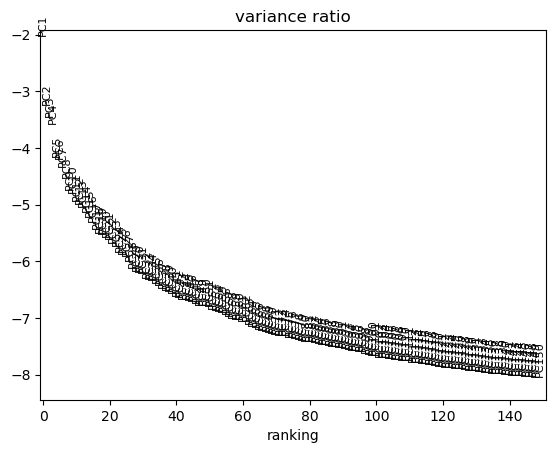

In [24]:
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=150)

Now we move `.X` and `.layers` out of the GPU.

In [25]:
%%time
rsc.utils.anndata_to_CPU(adata, convert_all=True)

CPU times: user 1.36 s, sys: 960 ms, total: 2.32 s
Wall time: 2.32 s


In [26]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 25.7966570854187


We have now finished the preprocessing of the data.

## Clustering and Visulization

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph using rsc.

Scanpy CPU implementation of nearest neighbor uses an approximation, while the GPU version calculates the excat graph. Both methods are valid, but you might see differences.

In [27]:
%%time
rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=60)

CPU times: user 4.97 s, sys: 114 ms, total: 5.08 s
Wall time: 5.17 s


Next we calculate the UMAP embedding using rapdis.

In [28]:
%%time
rsc.tl.umap(adata)

CPU times: user 1.24 s, sys: 75.3 ms, total: 1.31 s
Wall time: 1.31 s


### Clustering

Next, we use the Louvain and Leiden algorithm for graph-based clustering.

In [29]:
%%time
rsc.tl.louvain(adata,resolution=1.0)

CPU times: user 987 ms, sys: 2.2 s, total: 3.18 s
Wall time: 3.19 s


Currently there is a [bug with Leiden Clustering](https://github.com/rapidsai/cugraph/issues/3749) in `cugraph>=23.06` 

In [30]:
%%time
rsc.tl.leiden(adata,resolution=1.0)

CPU times: user 970 ms, sys: 2.19 s, total: 3.16 s
Wall time: 3.17 s


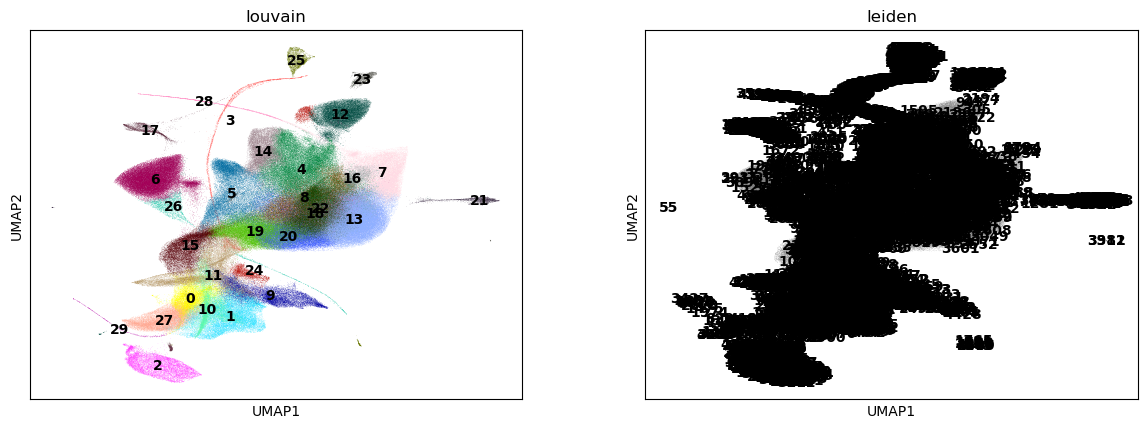

CPU times: user 6.77 s, sys: 204 ms, total: 6.97 s
Wall time: 6.81 s


In [31]:
%%time
sc.pl.umap(adata, color=["louvain","leiden"],legend_loc = 'on data')

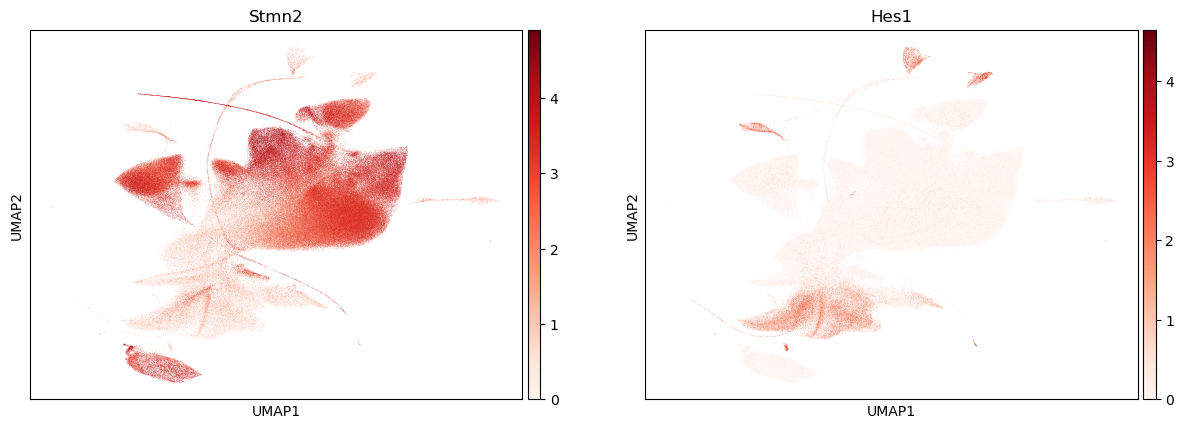

CPU times: user 3.37 s, sys: 160 ms, total: 3.53 s
Wall time: 3.35 s


In [32]:
%%time
sc.pl.umap(adata, color=["Stmn2","Hes1"],legend_loc = 'on data', cmap="Reds")

In [33]:
%%time
rsc.tl.diffmap(adata)

CPU times: user 2.58 s, sys: 9.06 s, total: 11.6 s
Wall time: 1.09 s


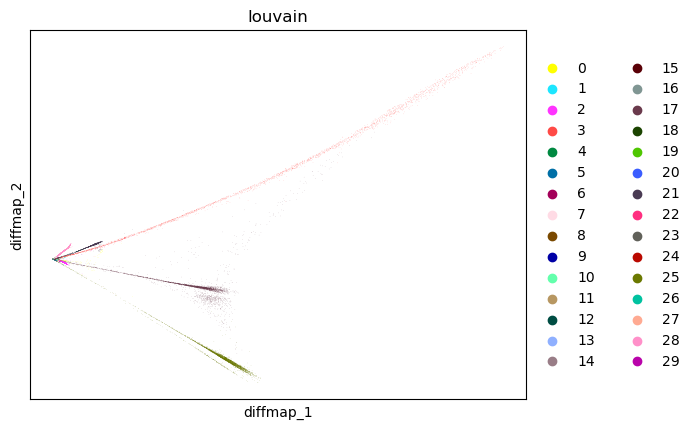

In [34]:
adata.obsm["X_diffmap_"] = adata.obsm["X_diffmap"][:, 1:] 
sc.pl.embedding(adata, "diffmap_", color="louvain")

In [35]:
%%time
rsc.tl.rank_genes_groups_logreg(adata, groupby="louvain", use_raw=False)

[W] [15:23:54.020971] L-BFGS: max iterations reached
[W] [15:23:54.022131] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
CPU times: user 1min 4s, sys: 3.59 s, total: 1min 7s
Wall time: 1min 7s


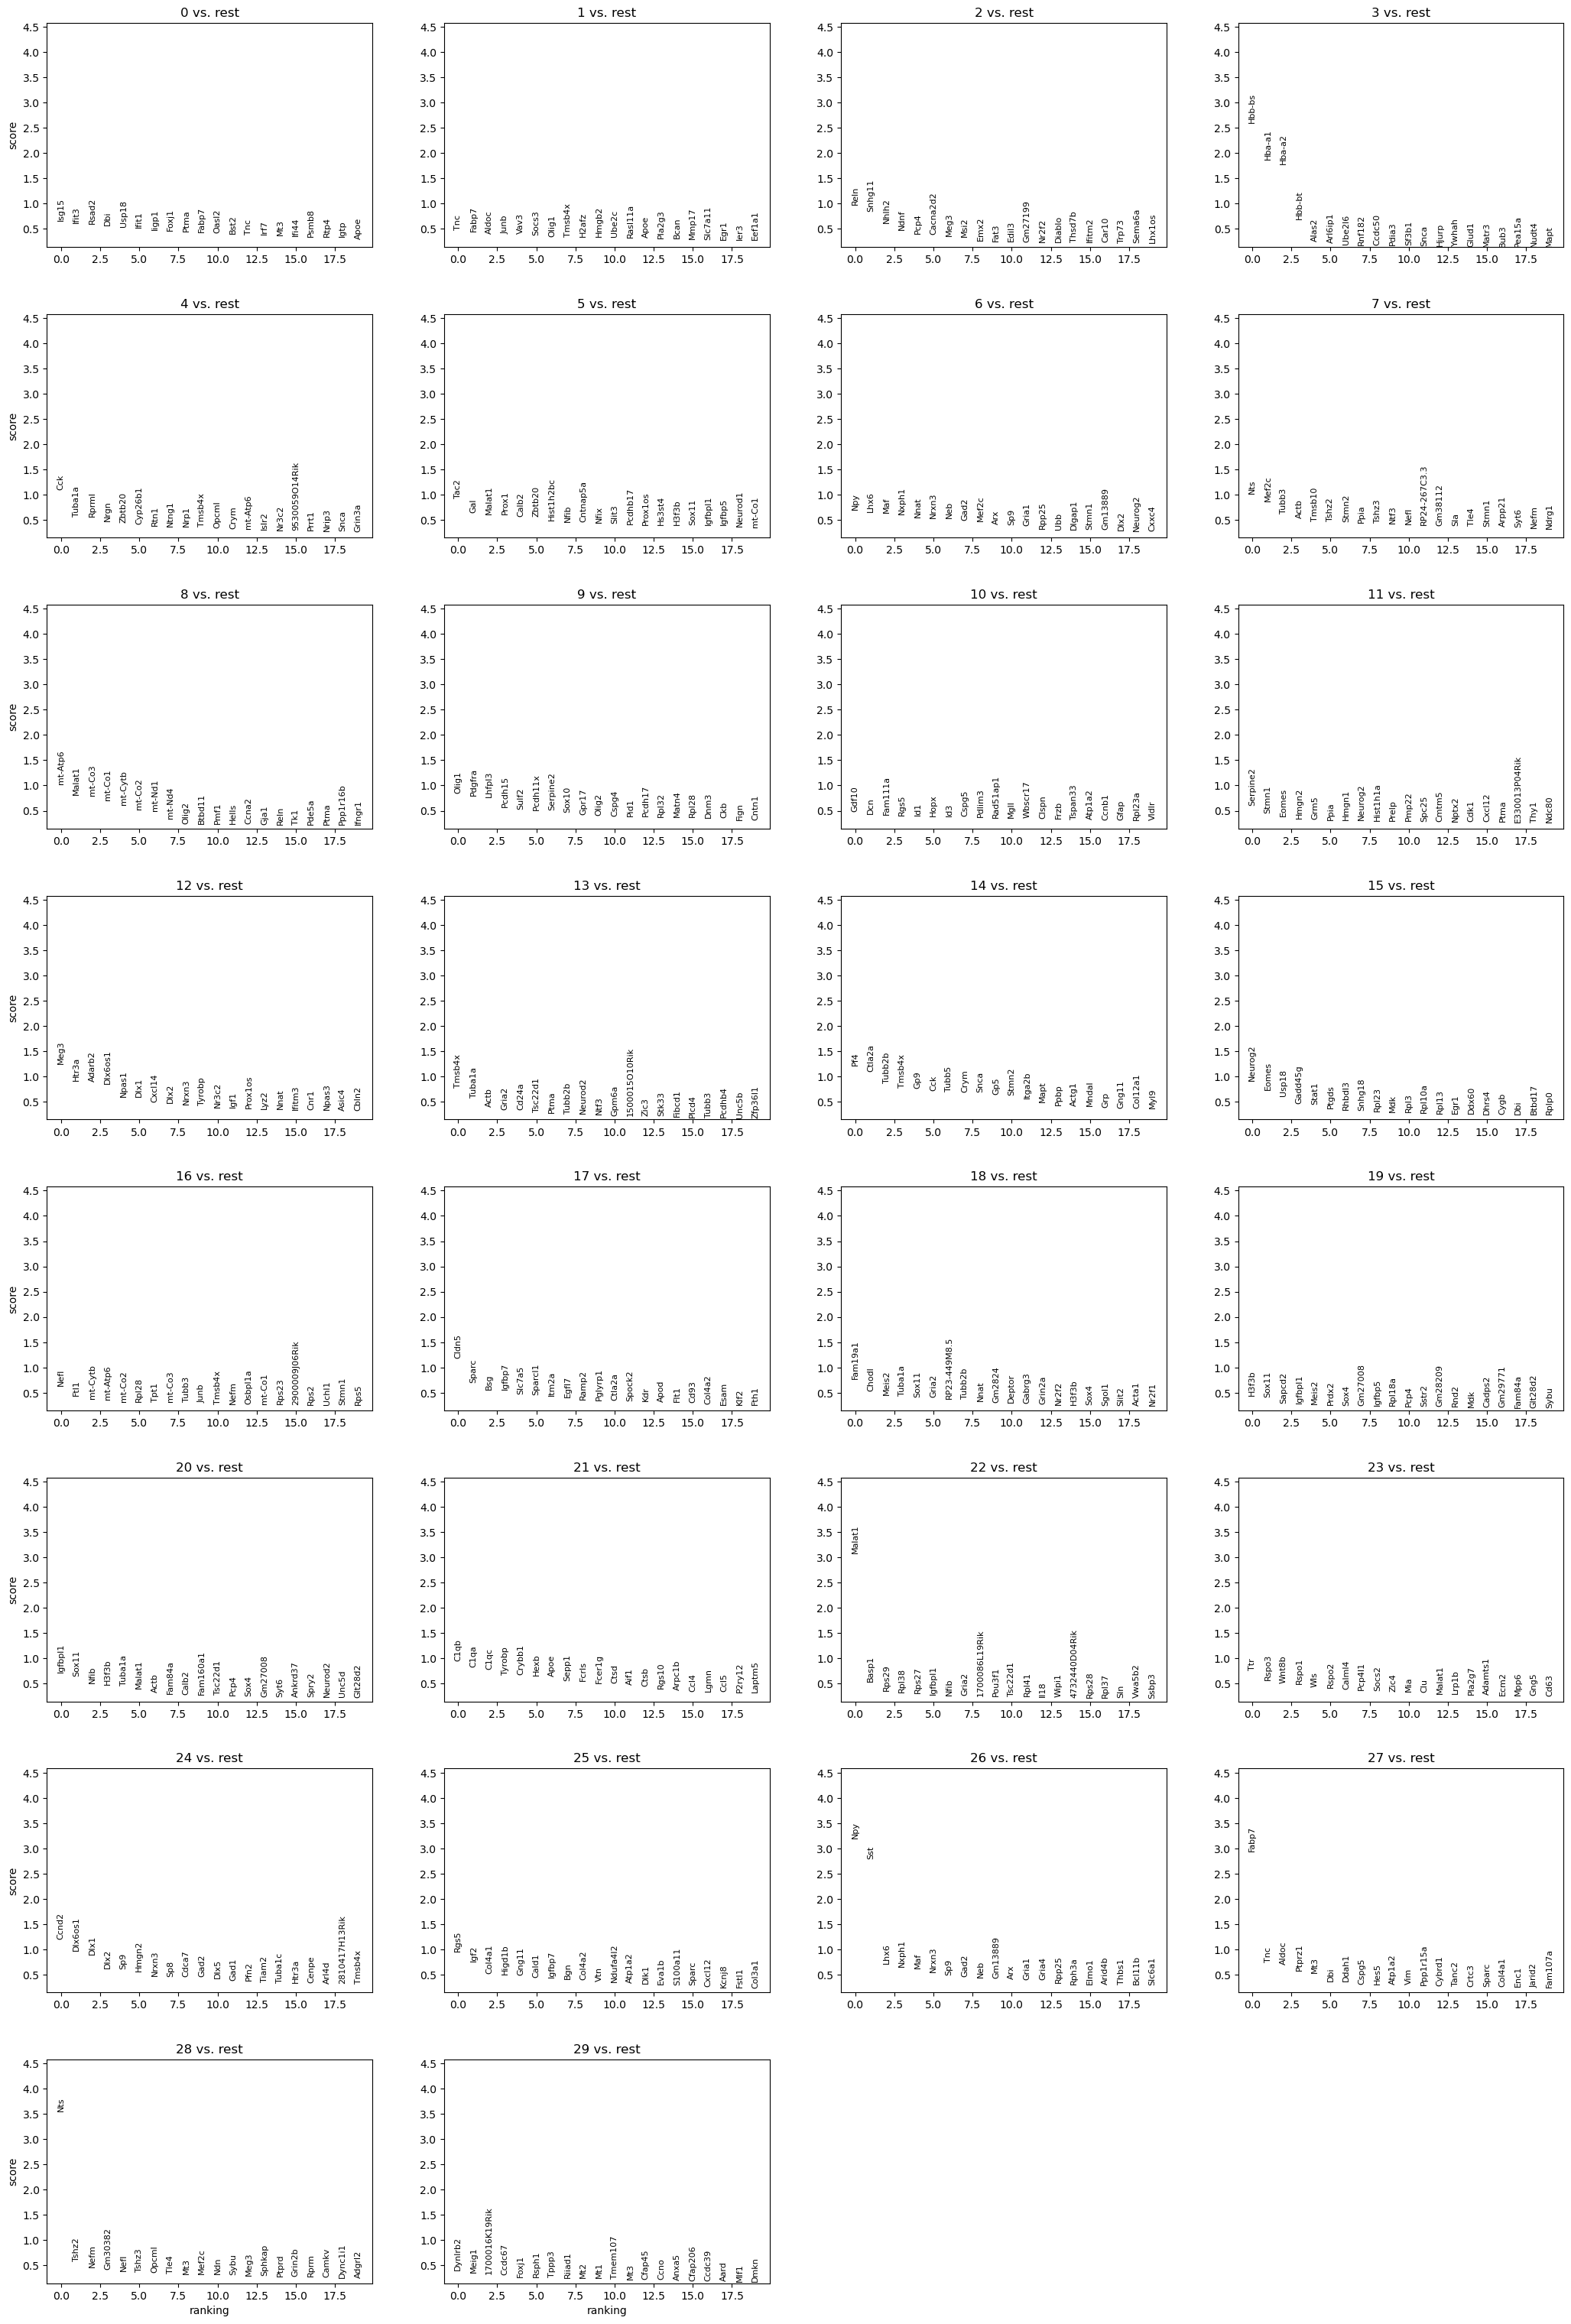

CPU times: user 3.28 s, sys: 185 ms, total: 3.46 s
Wall time: 3.29 s


In [36]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

In [37]:
print("Total Processing time: %s" % (time.time()-preprocess_start))

Total Processing time: 122.4615752696991
